In [1]:
from models import MeshModel, IcosphereModel
from models.mesh_transform import transform
from models.mesh_view import get_mesh_view, resolve_occlusion
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from geometry import clip, polygon_area
from geometry.utils import wrap
from jax.typing import ArrayLike
import jax

from jax import config
config.update("jax_enable_x64", True)


sol_rad = u.solRad.to(u.cm)

m1 = get_mesh_view(IcosphereModel.construct(1000, u.solRad.to(u.cm), 1.*u.solMass.to(u.kg), 1., jnp.concatenate([jnp.array([3.75]), jnp.ones(19)])), jnp.array([1., 0., 0.]))
m2 = get_mesh_view(transform(IcosphereModel.construct(1000, 0.75*u.solRad.to(u.cm), 1.*u.solMass.to(u.kg), 1., jnp.concatenate([jnp.array([3.75]), jnp.ones(19)])),
               jnp.array([3*u.solRad.to(u.cm), 0.25*u.solRad.to(u.cm), 0.])), jnp.array([1., 0., 0.]))

In [2]:
m1 = resolve_occlusion(m1, m2)

In [3]:
def visible_area(vertices1: ArrayLike, vertices2: ArrayLike) -> ArrayLike:
    clipped = jnp.nan_to_num(clip(vertices1, vertices2))
    return polygon_area(clipped[:, 0], clipped[:, 1])
total_visible_area = jax.jit(jax.vmap(visible_area, in_axes=(None, 0)))
visibility_areas = jax.jit(jax.vmap(total_visible_area, in_axes=(0, None)))

In [4]:
vs1 = m1.cast_vertices[m1.faces.astype(int)][m1.mus>0]
c1 = m1.cast_centers[m1.mus>0]
vs2 = m2.cast_vertices[m2.faces.astype(int)][m2.mus>0]
c2 = m2.cast_centers[m2.mus>0]
projected_areas = jax.jit(jax.vmap(polygon_area))
pa = projected_areas(vs1[:, :, 1], vs1[:, :, 2])
occluded_old = visibility_areas(vs1[:, :, [1, 2]], vs2[:, :, [1, 2]])

In [5]:
occluded_old.shape, vs1[:, :, 2].shape, jnp.sum(occluded_old, axis=0).shape

((624, 624), (624, 3), (624,))

In [6]:
vs1[:, :, 1].shape

(624, 3)

In [7]:
#m1.cast_centers[:, [1, 2]]-m2_center

In [8]:
#jnp.sqrt(jnp.sum(jnp.square(m1.cast_centers[:, [1, 2]]-m2_center), axis=1))<(m2.radius-mean_sep)

In [9]:
# plt.scatter(m1.cast_centers[:, 1], m1.cast_centers[:, 2],
#             c=jnp.sqrt(jnp.sum(jnp.square(m1.cast_centers[:, [1, 2]]-m2_center), axis=1))<(m2.radius-mean_sep), alpha=0.25)
# plt.scatter(m1.cast_centers[:, 1], m1.cast_centers[:, 2],
#             c=jnp.sqrt(jnp.sum(jnp.square(m1.cast_centers[:, [1, 2]]-m2_center), axis=1))<(m2.radius), alpha=0.25)
# plt.colorbar()

In [10]:
# fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
# ax[0].scatter(vs1[:, :, 1], vs1[:, :, 2], c='black')
# im = ax[1].scatter(c1[:, 1], c1[:, 2], c=occluded_old)
# plt.colorbar(im, ax=ax[1])
# ax[0].scatter(vs2[:, :, 1], vs2[:, :, 2], c='red')

In [11]:
N_GRID = 20

nx, ny = jnp.meshgrid(jnp.linspace(jnp.min(jnp.concatenate([vs1[:, :, 1], vs2[:, :, 1]])),
                                   jnp.max(jnp.concatenate([vs1[:, :, 1], vs2[:, :, 1]])), N_GRID),
                      jnp.linspace(jnp.min(jnp.concatenate([vs1[:, :, 2], vs2[:, :, 2]])),
                                   jnp.max(jnp.concatenate([vs1[:, :, 2], vs2[:, :, 2]])), N_GRID))
x, y = jnp.meshgrid(jnp.linspace(jnp.min(jnp.concatenate([vs1[:, :, 1], vs2[:, :, 1]])),
                                   jnp.max(jnp.concatenate([vs1[:, :, 1], vs2[:, :, 1]])), N_GRID),
                      jnp.linspace(jnp.min(jnp.concatenate([vs1[:, :, 2], vs2[:, :, 2]])),
                                   jnp.max(jnp.concatenate([vs1[:, :, 2], vs2[:, :, 2]])), N_GRID),
                      sparse=True)
x, y = x.flatten(), y.flatten()
grid = np.vstack([nx.ravel(), ny.ravel()]).T

In [12]:
x_range = jnp.linspace(jnp.min(jnp.concatenate([vs1[:, :, 1], vs2[:, :, 1]])), jnp.max(jnp.concatenate([vs1[:, :, 1], vs2[:, :, 1]])), N_GRID)
y_range = jnp.linspace(jnp.min(jnp.concatenate([vs1[:, :, 2], vs2[:, :, 2]])), jnp.max(jnp.concatenate([vs1[:, :, 2], vs2[:, :, 2]])), N_GRID)
x_span = x[1]-x[0]
y_span = y[1]-y[0]

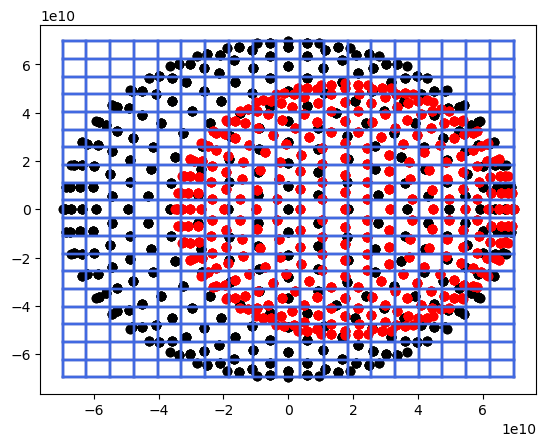

In [13]:
plt.scatter(vs1[:, :, 1], vs1[:, :, 2], c='black')
plt.scatter(vs2[:, :, 1], vs2[:, :, 2], c='red')
for i in range(len(grid)):
    # plt.plot(nx[i, :], ny[i, :], c='royalblue', alpha=0.5)
    # plt.plot(nx[:, i], ny[:, i], c='royalblue', alpha=0.5)
    plt.plot(jnp.repeat(grid[i, 0], len(grid)), grid[:, 1], c='royalblue', alpha=0.5)
    plt.plot(grid[:, 0], jnp.repeat(grid[i, 1], len(grid)), c='royalblue', alpha=0.5)

In [14]:
tzc = jnp.trim_zeros(m1.cast_centers[0])
def get_grid_index(tzc: ArrayLike) -> ArrayLike:
    return jnp.argwhere(jnp.isclose((tzc[0]-x)//x_span, 0.))[0].item(), jnp.argwhere(jnp.isclose((tzc[1]-y)//y_span, 0.))[0].item()
    #return jnp.argwhere(np.all(jnp.isclose((tzc-grid)//jnp.array([x_span, y_span]), 0.), axis=1)).flatten()[0].item()

In [15]:
(tzc[0]-x)//x_span, jnp.argwhere(jnp.isclose((tzc[0]-x)//x_span, 0.))

(Array([17., 16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,
         4.,  3.,  2.,  1.,  0., -1., -2.], dtype=float64),
 Array([[17]], dtype=int64))

In [16]:
get_grid_index(tzc)

(17, 10)

Number of labels: 3840


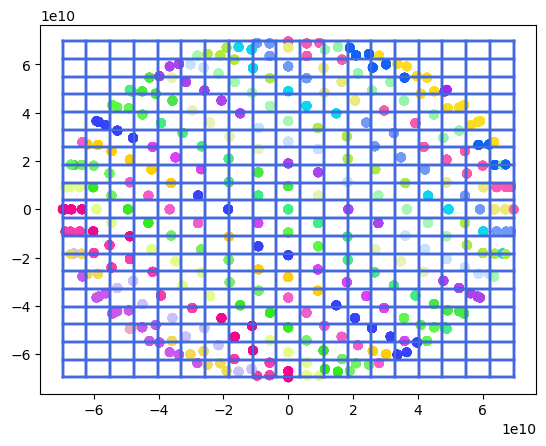

In [17]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    return random_colormap

cv1 = m1.cast_vertices[m1.faces.astype(int)][:, :, 1:].reshape((-1, 2))
new_cmap = rand_cmap(len(cv1), type='bright', first_color_black=True, last_color_black=False)

plt.scatter(cv1[:, 0], cv1[:, 1], c=[new_cmap(np.sum(get_grid_index(cv1i))) for cv1i in cv1])
for i in range(len(grid)):
    # plt.plot(nx[i, :], ny[i, :], c='royalblue', alpha=0.5)
    # plt.plot(nx[:, i], ny[:, i], c='royalblue', alpha=0.5)
    plt.plot(jnp.repeat(grid[i, 0], len(grid)), grid[:, 1], c='royalblue', alpha=0.5)
    plt.plot(grid[:, 0], jnp.repeat(grid[i, 1], len(grid)), c='royalblue', alpha=0.5)

/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_7246/4181531243.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('turbo')


(-86962500000.0, 86962500000.0)

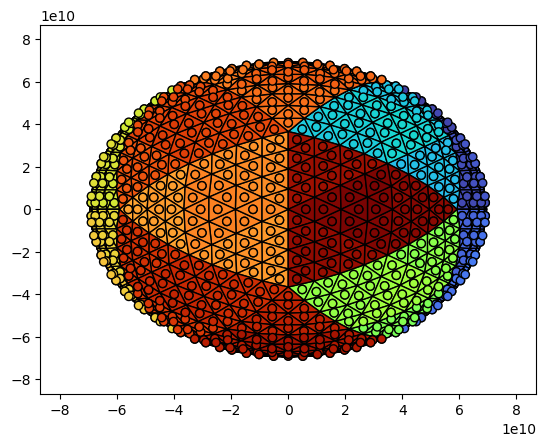

In [18]:
from matplotlib.collections import PolyCollection
import matplotlib

cmap = matplotlib.cm.get_cmap('turbo')
color_indices = np.linspace(0., 1., len(m1.faces))

fig, ax = plt.subplots(1, 1)
pc = PolyCollection(m1.cast_vertices[m1.faces.astype(int)][:, :, 1:], color=cmap(color_indices), edgecolor="black")
ax.add_artist(pc)
ax.scatter(m1.cast_centers[:, 1], m1.cast_centers[:, 2], c=cmap(color_indices), edgecolors='black')

ax.set_xlim(-1.25*m1.radius, 1.25*m1.radius)
ax.set_ylim(-1.25*m1.radius, 1.25*m1.radius)

In [19]:
from collections import defaultdict

N_POINTS = jnp.ceil(6*(m1.cast_centers.shape[0]/(N_GRID*N_GRID))).astype(int)
N_POINTS2 = jnp.ceil(6*(m2.cast_centers.shape[0]/(N_GRID*N_GRID))).astype(int)

grids_m1 = jnp.nan*jnp.ones((x.shape[0], y.shape[0], N_POINTS))
reverse_grids_m1 = jnp.nan*jnp.ones((m1.cast_centers.shape[0], 2))
grids_m2 = jnp.nan*jnp.ones((x.shape[0], y.shape[0], N_POINTS2))
reverse_grids_m2 = jnp.nan*jnp.ones((m2.cast_centers.shape[0], 2))

In [20]:
from geometry.utils import append_value_to_last_nan

for i in range(len(m1.cast_centers)):
    if m1.mus[i]>0:
        grid_index_x, grid_index_y = get_grid_index(m1.cast_centers[i, 1:])
        grids_m1 = grids_m1.at[grid_index_x, grid_index_y].set(append_value_to_last_nan(grids_m1[grid_index_x, grid_index_y], i))
        reverse_grids_m1 = reverse_grids_m1.at[i].set(jnp.array([grid_index_x, grid_index_y]))
    else:
        reverse_grids_m1 = reverse_grids_m1.at[i].set(jnp.array([jnp.nan, jnp.nan]))
    
for i in range(len(m2.cast_centers)):
    if m2.mus[i]>0:
        grid_index_x, grid_index_y = get_grid_index(m2.cast_centers[i, 1:])
        grids_m2 = grids_m2.at[grid_index_x, grid_index_y].set(append_value_to_last_nan(grids_m2[grid_index_x, grid_index_y], i))
        reverse_grids_m2 = reverse_grids_m2.at[i].set(jnp.array([grid_index_x, grid_index_y]))
    else:
        reverse_grids_m2 = reverse_grids_m2.at[i].set(jnp.array([jnp.nan, jnp.nan]))

In [21]:
@jax.jit
def get_neighbouring(x: int, y: int):
    neighbours = jnp.array([[x, y], [x-1, y-1], [x-1, y], [x-1, y+1],
                            [x, y-1], [x, y+1],
                            [x+1, y-1], [x+1, y], [x+1, y+1]])
    return neighbours

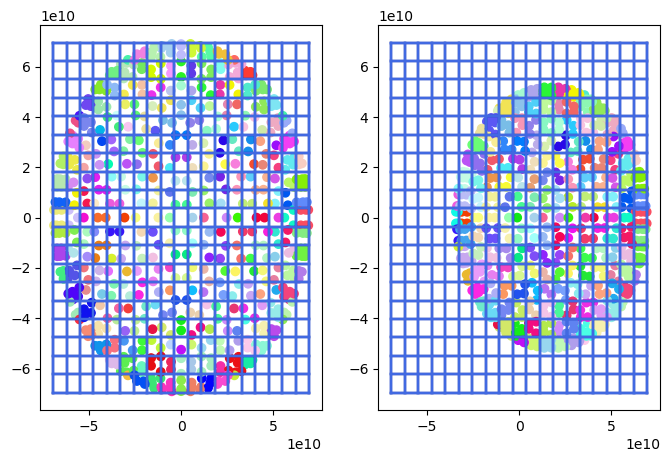

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
reverse_grid_to_one_dim = lambda x: 50*x[:, 0]+x[:, 1]
rvg = reverse_grid_to_one_dim(reverse_grids_m1[m1.mus>0])
rvg2 = reverse_grid_to_one_dim(reverse_grids_m2[m2.mus>0])
n = matplotlib.colors.Normalize(vmin=0, vmax=len(reverse_grids_m1))

ax[0].scatter(m1.cast_centers[m1.mus>0, 1], m1.cast_centers[m1.mus>0, 2], c=new_cmap(n(rvg)))
ax[1].scatter(m2.cast_centers[m2.mus>0, 1], m2.cast_centers[m2.mus>0, 2], c=new_cmap(n(rvg2)))

for i in range(len(grid)):
    ax[0].plot(jnp.repeat(grid[i, 0], len(grid)), grid[:, 1], c='royalblue', alpha=0.5)
    ax[0].plot(grid[:, 0], jnp.repeat(grid[i, 1], len(grid)), c='royalblue', alpha=0.5)
    ax[1].plot(jnp.repeat(grid[i, 0], len(grid)), grid[:, 1], c='royalblue', alpha=0.5)
    ax[1].plot(grid[:, 0], jnp.repeat(grid[i, 1], len(grid)), c='royalblue', alpha=0.5)

In [38]:
from models.utils import cast_to_los, cast_to_normal_plane

cast_to_normal_plane(m2.center, m1.los_vector)

Array([[0.00000e+00, 1.73925e+10, 0.00000e+00]], dtype=float64)

In [39]:
def occl(face_index: int):
    ix, iy = jnp.nan_to_num(reverse_grids_m1[face_index], reverse_grids_m1.shape[0]+1).astype(int)
    grid_neighbours = get_neighbouring(ix, iy)
    points_in_grid = (grids_m2[grid_neighbours[:, 0], grid_neighbours[:, 1]]).flatten()
    points_mask = jnp.where(jnp.isnan(points_in_grid), 0., 1.)*(m1.mus[face_index]>0).astype(float)
    return jnp.sum(total_visible_area(m1.cast_vertices[m1.faces[face_index].astype(int)][:, [1, 2]],
                                      m2.cast_vertices[m2.faces[points_in_grid.astype(int)].astype(int)][:, :, [1, 2]])*points_mask)

In [40]:
occl_vmap = jax.jit(jax.vmap(occl))

In [41]:
jnp.arange(len(m1.faces))

Array([   0,    1,    2, ..., 1277, 1278, 1279], dtype=int64)

In [42]:
# 100 - 5
# 200 - 10
# 500 - 73

In [143]:
from geometry.utils import get_cast_areas, cast_indexes

def calculate_occlusion():
    cast_mesh2_center = cast_to_normal_plane(m2.center, m1.los_vector)
    cast_mesh2_center = cast_mesh2_center[0, cast_indexes(cast_mesh2_center)]
    nonzero_indexer = cast_indexes(m1.cast_centers)
    mean_separation = jnp.mean(jnp.sqrt(2*m1.areas))
    o = occl_vmap(jnp.arange(len(m1.faces)))
    jax.debug.print("{a}", a = (jnp.sqrt(jnp.sum(jnp.square(m1.cast_vertices[m1.faces.astype(int)][:, :, nonzero_indexer]-cast_mesh2_center), axis=2))).shape)
    #return (jnp.sqrt(jnp.sum(jnp.square(m1.cast_centers[:, nonzero_indexer]-cast_mesh2_center), axis=1))<(m2.radius-mean_separation)).astype(float)
    return jnp.where(jnp.sqrt(jnp.sum(jnp.square(m1.cast_centers[:, nonzero_indexer]-cast_mesh2_center), axis=1))<(m2.radius-mean_separation),
                     0., m1.cast_areas-o)
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
# p1 = ax.scatter(m1.centers[m1.mus>0, 0], m1.centers[m1.mus>0, 2], c=jnp.clip(jnp.sum(occluded, axis=1)/projected_areas(vs1[:, :, 0], vs1[:, :, 2]), 0, 1), cmap='turbo')
# plt.colorbar(p1, ax=ax)

In [144]:
occluded = calculate_occlusion()

(1280, 3)


In [145]:
cast_mesh2_center = cast_to_normal_plane(m2.center, m1.los_vector)
cast_mesh2_center = cast_mesh2_center[0, cast_indexes(cast_mesh2_center)]
cast_mesh2_center

Array([1.73925e+10, 0.00000e+00], dtype=float64)

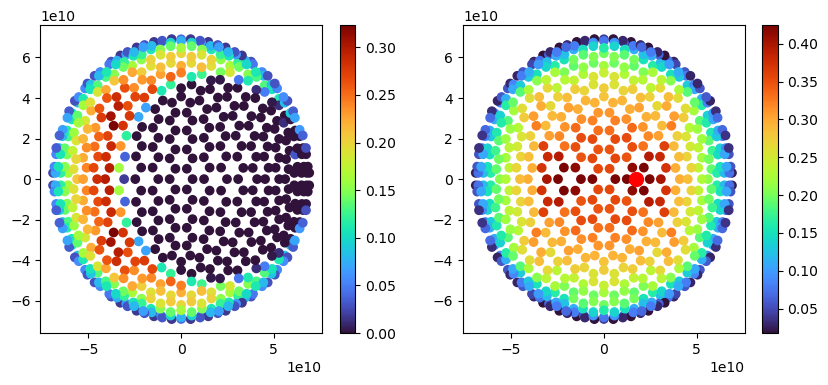

In [146]:
from matplotlib.colors import Normalize
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
n = Normalize(vmin=1e-10, vmax=1.25*1e20)

p1 = ax[0].scatter(m1.cast_centers[m1.mus>0, 1], m1.cast_centers[m1.mus>0, 2], c=n((occluded[m1.mus>0])), cmap='turbo') # m1.cast_areas[m1.mus>0]-
#ax[0].scatter(m2.cast_centers[m2.mus>0, 1], m2.cast_centers[m2.mus>0, 2], c='pink', alpha=0.25)
p2 = ax[1].scatter(m1.cast_centers[m1.mus>0, 1], m1.cast_centers[m1.mus>0, 2], c=n(m1.cast_areas[m1.mus>0]), cmap='turbo')
plt.scatter(*cast_mesh2_center, c='red', s=100)
plt.colorbar(p1, ax=ax[0])
plt.colorbar(p2, ax=ax[1])

In [31]:
jnp.max(occluded[m1.mus>0]), jnp.max(m1.cast_areas[m1.mus>0])

(Array(5.30737946e+19, dtype=float64), Array(5.30737946e+19, dtype=float64))

In [32]:
vs1.shape

(624, 3, 3)

In [33]:
occluded

Array([2.40135762e+19, 2.78114475e+19, 2.20627060e+19, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00], dtype=float64)

(-100000000000.0, 100000000000.0)

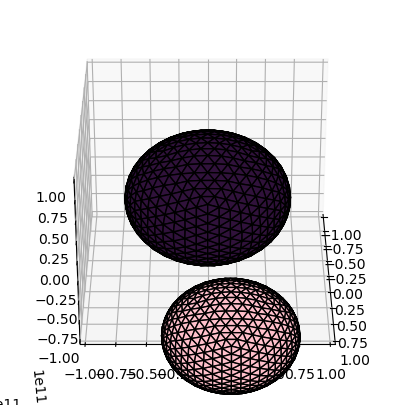

In [34]:
from mpl_toolkits.mplot3d import Axes3D, art3d
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection="3d")
pa = m1.cast_areas
c=jnp.nan_to_num((pa-occluded)/pa)[m1.mus>0] #jnp.clip((pa-occluded)/pa, 0, 1)
# c=jnp.clip(jnp.sum(a, axis=1)/projected_areas(vs1[:, :, 0], vs1[:, :, 2]), 0, 1)
n = plt.Normalize(vmin=np.min(c), vmax=np.max(c))

pc = art3d.Poly3DCollection(m1.vertices[m1.faces.astype(int)], facecolors=plt.cm.turbo(n(c)),
                            edgecolor="black")
pc2 = art3d.Poly3DCollection(m2.vertices[m2.faces.astype(int)], facecolors='pink', edgecolor='black')
ax.view_init(30, 0)
ax.add_collection(pc)
ax.add_collection(pc2)
ax.set_xlim(-1e11, 1e11)
ax.set_ylim(-1e11, 1e11)
ax.set_zlim(-1e11, 1e11)

In [35]:
c

Array([ 2.72912287e-15,  2.96911406e-13, -3.56453102e-14,  1.32888997e-01,
       -7.73618813e-15,  9.05171053e-15,  1.55211126e-13,  7.09524596e-03,
        2.35920487e-03,  0.00000000e+00, -2.25019403e-14,  7.06738745e-02,
       -3.97853456e-13,  3.60734719e-02, -2.22140983e-14,  0.00000000e+00,
        2.68229369e-15,  0.00000000e+00,  3.53813839e-15,  3.59033410e-15,
        7.11739319e-01,  3.54113297e-14,  1.32677964e-02,  1.41099174e-02,
        5.42617319e-02,  3.55150272e-15, -3.16694410e-14, -2.17756075e-14,
        1.91270629e-14, -1.54877522e-14,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        9.93841855e-01,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        0.00000000e+00, -7.04294004e-15,  6.71802322e-02,  0.00000000e+00,
        8.32159274e-01,  